# Benchmark HESC to Fibroblast

In [1]:
import os
import numpy as np
import pandas as pd
import anndata
import scanpy as sc
import seaborn as sns

BASE_DIR = '/sibcb1/chenluonanlab8/caideyu/CauTrigger_new/'
case_path = os.path.join(BASE_DIR, 'BenchmarkHESC/')
data_path = os.path.join(case_path, 'data/')
output_path = os.path.join(case_path, 'output/')
os.makedirs(output_path, exist_ok=True)

In [2]:
Trrust = pd.read_table(os.path.join(data_path, 'trrust_rawdata.human.tsv'), header=None)
Trrust_TF = Trrust.iloc[:, 0].dropna().unique()  # 827
Trrust_nonTF = np.setdiff1d(Trrust.iloc[:, 1].dropna().unique(), Trrust_TF)  #1629

In [3]:
expData = pd.read_csv(os.path.join(data_path, 'GSE75748_sc_cell_type_ec.csv.gz'), index_col=0).transpose()

adata = sc.AnnData(X=expData, dtype=np.float32)
adata.obs['cell_type'] = [index.split('_')[0] for index in adata.obs.index]
adata = adata[adata.obs['cell_type'].isin(['H1', 'HFF'])]
adata.obs['labels'] = adata.obs['cell_type'].map({'H1': 0, 'HFF': 1})
adata.obs['cell_type'] = adata.obs['cell_type'].map({'H1': 'ESC', 'HFF': 'Fibroblast'})
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

/sibcb1/chenluonanlab8/caideyu/miniconda3/envs/Project_CT/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/var/tmp/ipykernel_219582/186452163.py:7: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['labels'] = adata.obs['cell_type'].map({'H1': 0, 'HFF': 1})


In [4]:
sc.pp.highly_variable_genes(adata, n_top_genes=1000)
adata.var.loc[adata.var.index.isin(Trrust_TF), 'highly_variable'] = True
adata = adata[:, adata.var.highly_variable]
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=35)
sc.tl.leiden(adata, resolution=0.7)
adata.obs['manual_cluster'] = '0'
adata.layers['raw_count'] = adata.X.copy()

/sibcb1/chenluonanlab8/caideyu/miniconda3/envs/Project_CT/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm["X_pca"] = X_pca
/var/tmp/ipykernel_219582/2996530569.py:6: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=0.7)


In [ ]:
import celloracle as co
base_GRN = co.data.load_human_promoter_base_GRN()
oracle = co.Oracle()
oracle.import_anndata_as_normalized_count(adata=adata, cluster_column_name="manual_cluster", embedding_name="X_pca")
oracle.import_TF_data(TF_info_matrix=base_GRN)
oracle.perform_PCA()
n_comps = np.where(np.diff(np.diff(np.cumsum(oracle.pca.explained_variance_ratio_))>0.002))[0][0]
n_comps = min(n_comps, 50)
n_cell = oracle.adata.shape[0]
k = int(0.025*n_cell)
oracle.knn_imputation(n_pca_dims=n_comps, k=k, balanced=True, b_sight=k*8, b_maxl=k*4, n_jobs=4)
links = oracle.get_links(cluster_name_for_GRN_unit="manual_cluster", alpha=10, verbose_level=10, model_method='bayesian_ridge')
links.filter_links(p=0.001, weight="coef_abs", threshold_number=2000)
links.get_network_score()
gene_info_df = pd.DataFrame(links.merged_score['degree_centrality_all'].sort_values(ascending=False))

Loading prebuilt promoter base-GRN. Version: hg19_gimmemotifsv5_fpr2


... storing 'cell_type' as categorical
... storing 'manual_cluster' as categorical


  0%|          | 0/1 [00:00<?, ?it/s]

Inferring GRN for 0...


  0%|          | 0/1643 [00:00<?, ?it/s]

In [13]:
if 'SOX2' in gene_info_df.index:
    print('SOX2 index:', gene_info_df.index.get_loc('SOX2'))
else:
    print('SOX2 not found in gene_info_df.index')
if 'POU5F1' in gene_info_df.index:
    print('POU5F1 index:', gene_info_df.index.get_loc('POU5F1'))
else:
    print('POU5F1 not found in gene_info_df.index')
if 'OCT4' in gene_info_df.index:
    print('OCT4 index:', gene_info_df.index.get_loc('OCT4'))
else:
    print('OCT4 not found in gene_info_df.index')
if 'NANOG' in gene_info_df.index:
    print('NANOG index:', gene_info_df.index.get_loc('NANOG'))
else:
    print('NANOG not found in gene_info_df.index')
if 'KLF4' in gene_info_df.index:
    print('KLF4 index:', gene_info_df.index.get_loc('KLF4'))
else:
    print('KLF4 not found in gene_info_df.index')
if 'MYC' in gene_info_df.index:
    print('MYC index:', gene_info_df.index.get_loc('MYC'))
else:
    print('MYC not found in gene_info_df.index')
if 'LIN28A' in gene_info_df.index:
    print('LIN28A index:', gene_info_df.index.get_loc('LIN28A'))
else:
    print('LIN28A not found in gene_info_df.index')

print('length:', gene_info_df.shape[0])

SOX2 index: 293
POU5F1 index: 10
OCT4 not found in gene_info_df.index
NANOG index: 16
KLF4 index: 24
MYC index: 70
LIN28A not found in gene_info_df.index
length: 727


In [1]:
import os
import numpy as np
import pandas as pd
import anndata
import scanpy as sc
import seaborn as sns

BASE_DIR = '/sibcb1/chenluonanlab8/caideyu/CauTrigger_new/'
case_path = os.path.join(BASE_DIR, 'BenchmarkHESC/')
data_path = os.path.join(case_path, 'data/')
output_path = os.path.join(case_path, 'output/')
os.makedirs(output_path, exist_ok=True)

In [2]:
Trrust = pd.read_table(os.path.join(data_path, 'trrust_rawdata.human.tsv'), header=None)
Trrust_TF = Trrust.iloc[:, 0].dropna().unique()  # 827
Trrust_nonTF = np.setdiff1d(Trrust.iloc[:, 1].dropna().unique(), Trrust_TF)  #1629

In [3]:
expData = pd.read_csv(os.path.join(data_path, 'GSE75748_sc_cell_type_ec.csv.gz'), index_col=0).transpose()

adata = sc.AnnData(X=expData, dtype=np.float32)
adata.obs['cell_type'] = [index.split('_')[0] for index in adata.obs.index]
adata = adata[adata.obs['cell_type'].isin(['H1', 'HFF'])]
adata.obs['labels'] = adata.obs['cell_type'].map({'H1': 0, 'HFF': 1})
adata.obs['cell_type'] = adata.obs['cell_type'].map({'H1': 'ESC', 'HFF': 'Fibroblast'})
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

/sibcb1/chenluonanlab8/caideyu/miniconda3/envs/Project_CT/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/var/tmp/ipykernel_219939/186452163.py:7: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['labels'] = adata.obs['cell_type'].map({'H1': 0, 'HFF': 1})


In [4]:
sc.pp.highly_variable_genes(adata, n_top_genes=500)
adata.var.loc[adata.var.index.isin(Trrust_TF), 'highly_variable'] = True
adata = adata[:, adata.var.highly_variable]

In [5]:
import cefcon as cf
network_data = pd.read_csv(os.path.join(data_path, 'NicheNet_human.csv'), index_col=None, header=0)
data = cf.data_preparation(input_expData=adata, input_priorNet=network_data)
cefcon_results_dict = {}
for li, data_li in data.items():
    cefcon_GRN_model = cf.NetModel(epochs=350, repeats=1, cuda='1')
    cefcon_GRN_model.run(data_li)
    cefcon_results = cefcon_GRN_model.get_cefcon_results(edge_threshold_avgDegree=8)
    cefcon_results_dict[li] = cefcon_results
for li, result_li in cefcon_results_dict.items():
    print(f'Lineage - {li}:')
    result_li.gene_influence_score()
    result_li.driver_regulators()
result_all = cefcon_results_dict['all']
gene_info_df2 = result_all.driver_regulator.sort_values(by='influence_score', ascending=False)

[0] - Data loading and preprocessing...
Consider the input data with 1 lineages:
  Lineage - all:
    13791 extra edges (Spearman correlation > 0.6) are added into the prior gene interaction network.
    Total number of edges: 208805.
    n_genes × n_cells = 1231 × 371
[1] - Constructing cell-lineage-specific GRN...
  Lineage - all: 


  Iter: 1/1: 100%|███████████████| 350/350 [01:16<00:00,  4.60it/s, loss=0.000267, min_loss=4.38e-5]
/sibcb1/chenluonanlab8/caideyu/miniconda3/envs/Project_CT/lib/python3.10/site-packages/cefcon/cell_lineage_GRN.py:487: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1831.)
  'weights_std': scaled_att_coefs_combined.std(1, keepdim=False).numpy()}


Lineage - all:
[2] - Identifying driver regulators...
Restricted license - for non-production use only - expires 2025-11-24
  Solving MFVS problem...
    128 critical nodes are found.
    23 nodes left after graph reduction operation.
    Solving the Integer Linear Programming problem on the reduced graph...
optimal value with GUROBI:11.0,  status:optimal)
  139 MFVS driver nodes are found.
  Solving MDS problem...
    105 critical nodes are found.
    418 nodes left after graph reduction operation.
    Solving the Integer Linear Programming problem on the reduced graph...
      Solving by GUROBI...(optimal value with GUROBI:82.0,  status:optimal)
  187 MDS driver genes are found.


In [6]:
if 'SOX2' in gene_info_df2.index:
    print('SOX2 index:', gene_info_df2.index.get_loc('SOX2'))
else:
    print('SOX2 not found in gene_info_df.index')
if 'POU5F1' in gene_info_df2.index:
    print('POU5F1 index:', gene_info_df2.index.get_loc('POU5F1'))
else:
    print('POU5F1 not found in gene_info_df.index')
if 'OCT4' in gene_info_df2.index:
    print('OCT4 index:', gene_info_df2.index.get_loc('OCT4'))
else:
    print('OCT4 not found in gene_info_df.index')
if 'NANOG' in gene_info_df2.index:
    print('NANOG index:', gene_info_df2.index.get_loc('NANOG'))
else:
    print('NANOG not found in gene_info_df.index')
if 'KLF4' in gene_info_df2.index:
    print('KLF4 index:', gene_info_df2.index.get_loc('KLF4'))
else:
    print('KLF4 not found in gene_info_df.index')
if 'MYC' in gene_info_df2.index:
    print('MYC index:', gene_info_df2.index.get_loc('MYC'))
else:
    print('MYC not found in gene_info_df.index')
if 'LIN28A' in gene_info_df2.index:
    print('LIN28A index:', gene_info_df2.index.get_loc('LIN28A'))
else:
    print('LIN28A not found in gene_info_df.index')

print('length:', gene_info_df2.shape[0])

SOX2 index: 7
POU5F1 index: 2
OCT4 not found in gene_info_df.index
NANOG index: 3
KLF4 not found in gene_info_df.index
MYC index: 14
LIN28A index: 185
length: 247


In [11]:
from pyscenic.utils import load_motifs
from pyscenic.aucell import aucell
from pyscenic.rss import regulon_specificity_scores
from pyscenic.cli.utils import load_signatures
RESOURCES_FOLDERNAME = data_path
RESULTS_FOLDERNAME = output_path
FIGURES_FOLDERNAME = output_path
AUXILLIARIES_FOLDERNAME = data_path
DATASET_ID = 'h2fibro'

RANKING_DBS_FNAMES = list(map(lambda fn: os.path.join(AUXILLIARIES_FOLDERNAME, fn),
                   ['hg19-500bp-upstream-7species.mc9nr.genes_vs_motifs.rankings.feather',
                   'hg19-500bp-upstream-10species.mc9nr.genes_vs_motifs.rankings.feather',
                   'hg19-tss-centered-10kb-10species.mc9nr.genes_vs_motifs.rankings.feather',
                   'hg19-tss-centered-10kb-7species.mc9nr.genes_vs_motifs.rankings.feather',
                   'hg19-tss-centered-5kb-10species.mc9nr.genes_vs_motifs.rankings.feather',
                    'hg19-tss-centered-5kb-7species.mc9nr.genes_vs_motifs.rankings.feather']))        
MOTIF_ANNOTATIONS_FNAME = os.path.join(RESOURCES_FOLDERNAME, 'motifs-v9-nr.hgnc-m0.001-o0.0.tbl')
MM_TFS_FNAME = os.path.join(RESULTS_FOLDERNAME, 'hg_tfs.txt')
COUNTS_QC_MTX_FNAME = os.path.join(RESULTS_FOLDERNAME, f'{DATASET_ID}.qc.counts.csv')
ADJACENCIES_FNAME = os.path.join(RESULTS_FOLDERNAME, f'{DATASET_ID}.adjacencies.tsv')
MOTIFS_FNAME = os.path.join(RESULTS_FOLDERNAME, f'{DATASET_ID}.motifs.csv')
pd_motifs = pd.read_csv(MOTIF_ANNOTATIONS_FNAME, sep='\t')
mm_tfs = pd_motifs.gene_name.unique()
with open(MM_TFS_FNAME, 'wt') as f:
    f.write('\n'.join(mm_tfs) + '\n')

/var/tmp/ipykernel_219939/3858529808.py:23: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  pd_motifs = pd.read_csv(MOTIF_ANNOTATIONS_FNAME, sep='\t')


In [12]:
expData = pd.read_csv(os.path.join(data_path, 'GSE75748_sc_cell_type_ec.csv.gz'), index_col=0).transpose()
adata = sc.AnnData(X=expData, dtype=np.float32)
adata.obs['cell_type'] = [index.split('_')[0] for index in adata.obs.index]
adata = adata[adata.obs['cell_type'].isin(['H1', 'HFF'])]
adata.obs['cell_type'] = 'RSS'
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=1000)
adata.var.loc[adata.var.index.isin(Trrust_TF), 'highly_variable'] = True
adata = adata[:, adata.var.highly_variable]

df_counts_qc = adata.to_df()
df_counts_qc.to_csv(COUNTS_QC_MTX_FNAME)

/sibcb1/chenluonanlab8/caideyu/miniconda3/envs/Project_CT/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/var/tmp/ipykernel_219939/1538864227.py:6: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['cell_type'] = 'RSS'


In [60]:
!~/miniconda3/envs/Project_CT/bin/pyscenic grn {COUNTS_QC_MTX_FNAME} {MM_TFS_FNAME} -o {ADJACENCIES_FNAME} --num_workers 1

In [63]:
# STEP 2-3: Regulon prediction aka cisTarget from CLI
DBS_PARAM = ' '.join(RANKING_DBS_FNAMES)
!~/miniconda3/envs/Project_CT/bin/pyscenic ctx {ADJACENCIES_FNAME} {DBS_PARAM} --annotations_fname {MOTIF_ANNOTATIONS_FNAME} --expression_mtx_fname {COUNTS_QC_MTX_FNAME} --output {MOTIFS_FNAME} --num_workers 6

In [16]:
# STEP 4: Cellular enrichment aka AUCell
sig = load_signatures(MOTIFS_FNAME)
auc_mtx = aucell(df_counts_qc, sig, num_workers=1)
rss = regulon_specificity_scores(auc_mtx, adata.obs.cell_type)
df = rss.transpose()
df.rename(index=lambda x: x.replace("(+)", ""), inplace=True)
df = pd.DataFrame(df).sort_values(by='RSS', ascending=False)

Create regulons from a dataframe of enriched features.
Additional columns saved: []


100%|██████████| 339/339 [00:05<00:00, 64.89it/s] 


In [18]:
if 'SOX2' in df.index:
    print('SOX2 index:', df.index.get_loc('SOX2'))
else:
    print('SOX2 not found in gene_info_df.index')
if 'POU5F1' in df.index:
    print('POU5F1 index:', df.index.get_loc('POU5F1'))
else:
    print('POU5F1 not found in gene_info_df.index')
if 'OCT4' in df.index:
    print('OCT4 index:', df.index.get_loc('OCT4'))
else:
    print('OCT4 not found in gene_info_df.index')
if 'NANOG' in df.index:
    print('NANOG index:', df.index.get_loc('NANOG'))
else:
    print('NANOG not found in gene_info_df.index')
if 'KLF4' in df.index:
    print('KLF4 index:', df.index.get_loc('KLF4'))
else:
    print('KLF4 not found in gene_info_df.index')
if 'MYC' in df.index:
    print('MYC index:', df.index.get_loc('MYC'))
else:
    print('MYC not found in gene_info_df.index')
if 'LIN28A' in df.index:
    print('LIN28A index:', df.index.get_loc('LIN28A'))
else:
    print('LIN28A not found in gene_info_df.index')

print('length:', df.shape[0])

SOX2 index: 81
POU5F1 index: 35
OCT4 not found in gene_info_df.index
NANOG index: 86
KLF4 not found in gene_info_df.index
MYC index: 68
LIN28A not found in gene_info_df.index
length: 339


In [ ]:
# CellOracle
# SOX2 index: 293
# POU5F1 index: 10
# OCT4 not found in gene_info_df.index
# NANOG index: 16
# KLF4 index: 24
# MYC index: 70
# LIN28A not found in gene_info_df.index
# length: 727

# CEFCON
# SOX2 index: 7
# POU5F1 index: 2
# OCT4 not found in gene_info_df.index
# NANOG index: 3
# KLF4 not found in gene_info_df.index
# MYC index: 14
# LIN28A index: 185
# length: 247

# SCENIC
# SOX2 index: 81
# POU5F1 index: 35
# OCT4 not found in gene_info_df.index
# NANOG index: 86
# KLF4 not found in gene_info_df.index
# MYC index: 68
# LIN28A not found in gene_info_df.index
# length: 339

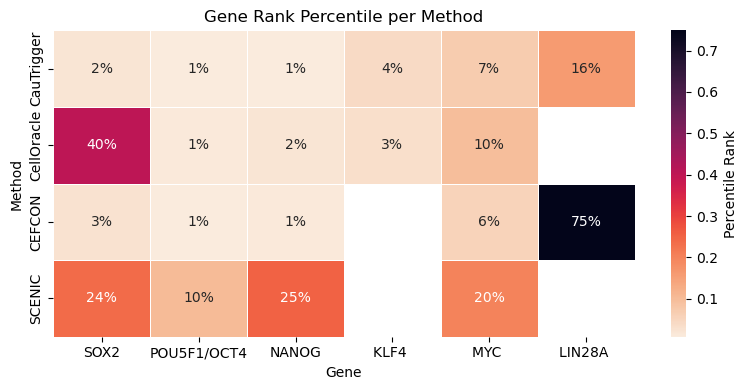

In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

data = {
    'SOX2': [0.02, 293/727, 7/247, 81/339],
    'POU5F1/OCT4': [0.01, 10/727, 2/247, 35/339],
    'NANOG': [0.01, 16/727, 3/247, 86/339],
    'KLF4 ': [0.04, 24/727, np.nan, np.nan],
    'MYC ': [0.07, 70/727, 14/247, 68/339],
    'LIN28A ': [0.16, np.nan, 185/247, np.nan],
}
methods = ['CauTrigger', 'CellOracle', 'CEFCON', 'SCENIC']
df = pd.DataFrame(data, index=methods)

annot = df.copy()
annot = annot.applymap(lambda x: f"{x * 100:.0f}%" if pd.notnull(x) else '\\')

cmap = sns.cm.rocket_r
mask = df.isnull()

plt.figure(figsize=(8, 4))
sns.heatmap(df, annot=annot, fmt='', cmap=cmap, linewidths=0.5, linecolor='white', mask=mask,
            cbar_kws={'label': 'Percentile Rank'})
plt.title("Gene Rank Percentile per Method")
plt.ylabel("Method")
plt.xlabel("Gene")
plt.tight_layout()
plt.savefig(output_path+'ESC2Fibro_rank.pdf')
plt.show()